<a href="https://colab.research.google.com/github/Dhanush-sai-reddy/uponcv-csv/blob/main/Synapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Synapse_Dataset.zip

Archive:  /content/drive/MyDrive/Synapse_Dataset.zip
   creating: Synapse_Dataset/
  inflating: Synapse_Dataset/README.md  
   creating: Synapse_Dataset/Session1/
   creating: Synapse_Dataset/Session1/session1_subject_1/
  inflating: Synapse_Dataset/Session1/session1_subject_1/gesture00_trial01.csv  
  inflating: Synapse_Dataset/Session1/session1_subject_1/gesture00_trial02.csv  
  inflating: Synapse_Dataset/Session1/session1_subject_1/gesture00_trial03.csv  
  inflating: Synapse_Dataset/Session1/session1_subject_1/gesture00_trial04.csv  
  inflating: Synapse_Dataset/Session1/session1_subject_1/gesture00_trial05.csv  
  inflating: Synapse_Dataset/Session1/session1_subject_1/gesture00_trial06.csv  
  inflating: Synapse_Dataset/Session1/session1_subject_1/gesture00_trial07.csv  
  inflating: Synapse_Dataset/Session1/session1_subject_1/gesture01_trial01.csv  
  inflating: Synapse_Dataset/Session1/session1_subject_1/gesture01_trial02.csv  
  inflating: Synapse_Dataset/Session1/session1_sub

In [3]:
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from xgboost import XGBClassifier
from scipy.stats import mode


In [4]:
def rms(x):
    return np.sqrt(np.mean(x**2))

def mav(x):
    return np.mean(np.abs(x))

def wl(x):
    return np.sum(np.abs(np.diff(x)))

def zero_crossing(x, threshold=0.01):
    x1, x2 = x[:-1], x[1:]
    return np.sum((x1 * x2 < 0) & (np.abs(x1 - x2) >= threshold))

def slope_sign_change(x, threshold=0.01):
    x1, x2, x3 = x[:-2], x[1:-1], x[2:]
    return np.sum(
        ((x2 - x1) * (x2 - x3) > 0) &
        ((np.abs(x2 - x1) >= threshold) |
         (np.abs(x2 - x3) >= threshold))
    )


In [5]:
def extract_window_features_from_csv(
    csv_path,
    window_size=256,
    step_size=128
):
    df = pd.read_csv(csv_path)
    df = df.select_dtypes(include=[np.number])

    if df.shape[1] > 8:
        df = df.iloc[:, -8:]

    data = df.to_numpy(dtype=np.float64)

    window_features = []

    for start in range(0, data.shape[0] - window_size + 1, step_size):
        feats = []
        for ch in range(8):
            w = data[start:start + window_size, ch]

            feats.extend([
                rms(w),
                mav(w),
                wl(w),
                zero_crossing(w),
                slope_sign_change(w)
            ])
        window_features.append(feats)

    return np.array(window_features)   # (num_windows, 40)


In [6]:
def load_dataset_windows(root_dir):
    X, y, trial_ids, subjects = [], [], [], []
    trial_counter = 0

    for session_name in os.listdir(root_dir):
        session_path = os.path.join(root_dir, session_name)
        if not os.path.isdir(session_path):
            continue

        for subject_name in os.listdir(session_path):
            subject_path = os.path.join(session_path, subject_name)
            if not os.path.isdir(subject_path):
                continue

            subject_id = int(subject_name.split("_")[-1])

            for file in os.listdir(subject_path):
                if not file.endswith(".csv"):
                    continue

                gesture_id = int(file.split("_")[0].replace("gesture", ""))
                csv_path = os.path.join(subject_path, file)

                win_feats = extract_window_features_from_csv(csv_path)

                for wf in win_feats:
                    X.append(wf)
                    y.append(gesture_id)
                    trial_ids.append(trial_counter)
                    subjects.append(subject_id)

                trial_counter += 1

    return (
        np.array(X),
        np.array(y),
        np.array(trial_ids),
        np.array(subjects)
    )


In [7]:
ROOT_DIR = "/content/Synapse_Dataset"

X, y, trial_ids, subjects = load_dataset_windows(ROOT_DIR)

print(X.shape)   # (num_windows, 40)


(49875, 40)


In [8]:
def subject_wise_normalization(X, subjects):
    Xn = np.zeros_like(X)

    for s in np.unique(subjects):
        idx = subjects == s
        mu = X[idx].mean(axis=0)
        std = X[idx].std(axis=0)
        std[std == 0] = 1.0
        Xn[idx] = (X[idx] - mu) / std

    return Xn

X = subject_wise_normalization(X, subjects)


In [9]:
train_subjects = np.arange(1, 21)
test_subjects  = np.arange(21, 26)

train_idx = np.isin(subjects, train_subjects)
test_idx  = np.isin(subjects, test_subjects)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
trial_test = trial_ids[test_idx]


In [10]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

In [11]:
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_class=5, ...)

In [12]:
rf_probs  = rf.predict_proba(X_test)
xgb_probs = xgb.predict_proba(X_test)

rf_conf  = rf_probs.max(axis=1)
xgb_conf = xgb_probs.max(axis=1)

y_pred_windows = []

for i in range(len(X_test)):
    if rf_conf[i] >= xgb_conf[i]:
        y_pred_windows.append(np.argmax(rf_probs[i]))
    else:
        y_pred_windows.append(np.argmax(xgb_probs[i]))

y_pred_windows = np.array(y_pred_windows)


In [13]:
y_true_trials = []
y_pred_trials = []

for t in np.unique(trial_test):
    idx = trial_test == t

    y_true_trials.append(
        mode(y_test[idx], keepdims=False).mode
    )
    y_pred_trials.append(
        mode(y_pred_windows[idx], keepdims=False).mode
    )


In [14]:
acc = accuracy_score(y_true_trials, y_pred_trials)
cm  = confusion_matrix(y_true_trials, y_pred_trials)

print("Ensemble Trial Accuracy:", acc)
print("Confusion Matrix:\n", cm)


Ensemble Trial Accuracy: 0.7542857142857143
Confusion Matrix:
 [[ 69   1   4  30   1]
 [  2  67  27   7   2]
 [ 10  18  74   3   0]
 [ 15   4   4  81   1]
 [  0   0   0   0 105]]


In [19]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the gesture labels
ohe = OneHotEncoder(sparse_output=False, categories='auto')
y_one_hot = ohe.fit_transform(y.reshape(-1, 1))

gesture_names = [f'Gesture_{i}' for i in range(y_one_hot.shape[1])]
y_one_hot_df = pd.DataFrame(y_one_hot, columns=gesture_names)

X_df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(X.shape[1])])

correlation_matrix = X_df.apply(lambda x: y_one_hot_df.corrwith(x)).T

print("Shape of correlation matrix:", correlation_matrix.shape)

Shape of correlation matrix: (40, 5)


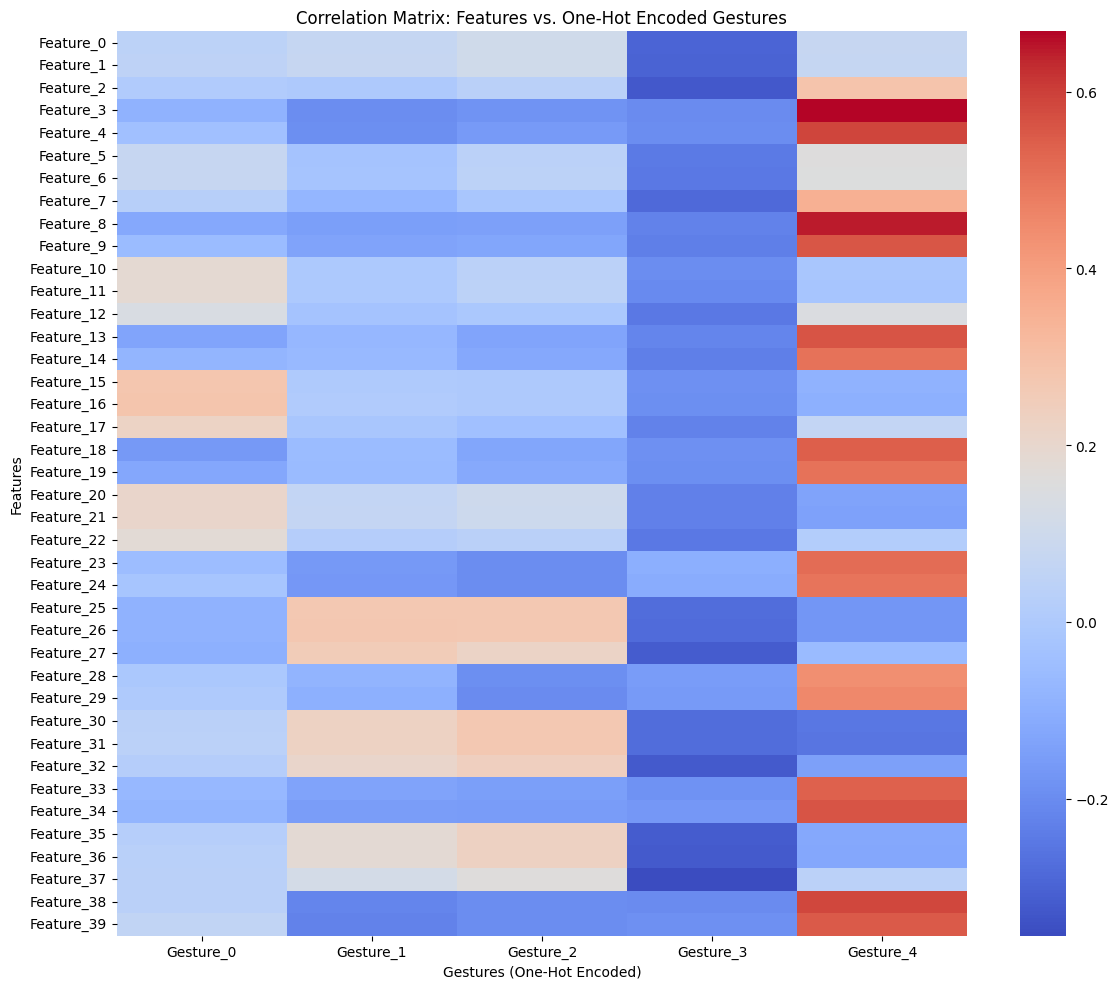

In [20]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Features vs. One-Hot Encoded Gestures')
plt.xlabel('Gestures (One-Hot Encoded)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

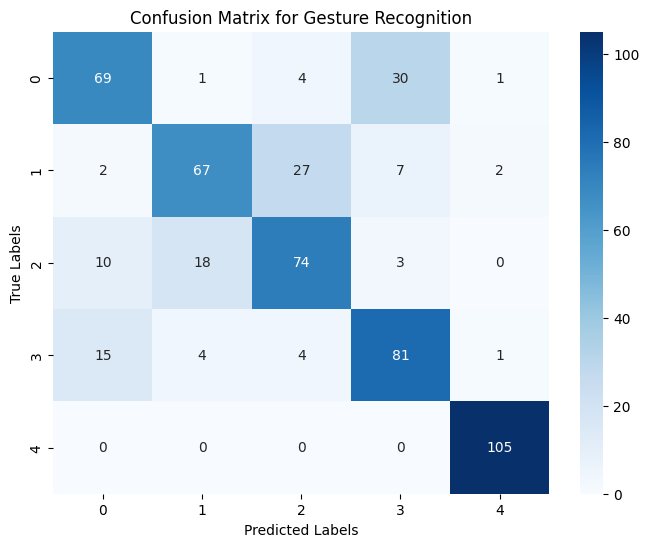

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Gesture Recognition')
plt.show()